
# Assignment 8 — From GANs to WGANs using FashionMNIST


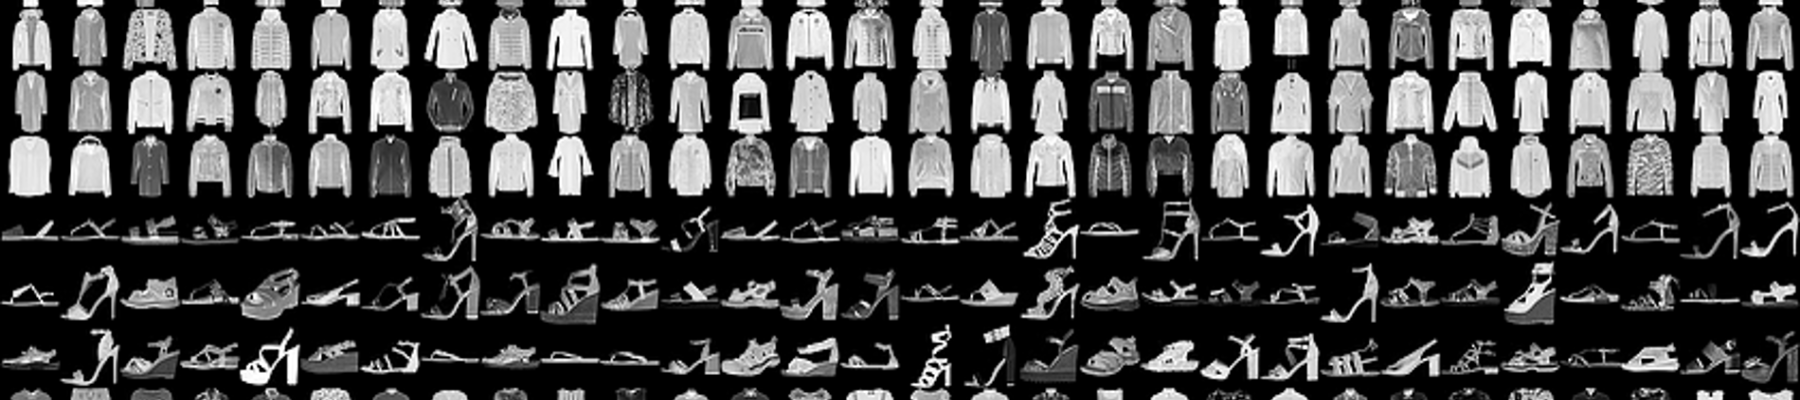


In [ ]:
# Basic imports and configuration (plain PyTorch)
import os
import math
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils

import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:
# Dataset: FashionMNIST (28 x 28 grayscale)
batch_size = 128
num_workers = 2

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # scale to [-1, 1]
])

train_ds = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

len(train_ds), len(test_ds)


100%|██████████| 26.4M/26.4M [00:02<00:00, 13.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 196kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.75MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.7MB/s]


(60000, 10000)

In [ ]:
# Utility: visualize a grid of images (values in [-1,1] assumed)
def show_grid(tensor, title=None, nrow=8):
    tensor = tensor.detach().cpu()
    grid = vutils.make_grid(tensor, nrow=nrow, normalize=True, value_range=(-1, 1))
    plt.figure(figsize=(6,6))
    if title:
        plt.title(title)
    plt.axis("off")
    plt.imshow(grid.permute(1,2,0))
    plt.show()



## Part A — Observing a Vanilla GAN (Demo)

**Goal:** Run a simple GAN on FashionMNIST for 5 epochs and observe instability or noisy samples.




In [ ]:
# Simple Vanilla GAN: Generator and Discriminator (with final sigmoid in the discriminator)
latent_dim = 64

class GenA(nn.Module):
    def __init__(self, z_dim=latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 28*28),
            nn.Tanh(),  # output in [-1,1]
        )
    def forward(self, z):
        out = self.net(z).view(-1, 1, 28, 28)
        return out

class DiscA(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),  # Vanilla GAN uses sigmoid + BCE
        )
    def forward(self, x):
        return self.net(x.view(x.size(0), -1))

G_A = GenA().to(device)
D_A = DiscA().to(device)


In [ ]:
# Training setup for Vanilla GAN
epochs_gan = 5  # as requested
lr = 2e-4
beta1, beta2 = 0.5, 0.999

criterion_bce = nn.BCELoss()
opt_G_A = torch.optim.Adam(G_A.parameters(), lr=lr, betas=(beta1, beta2))
opt_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(beta1, beta2))

fixed_noise = torch.randn(64, latent_dim, device=device)

losses_G_A, losses_D_A = [], []


2. Train the GAN for 5 epochs, observe, and analyze plots

Starting Vanilla GAN Training...
Epoch [1/5], Batch [100/469], D Loss: 0.8034, G Loss: 0.8624
Epoch [1/5], Batch [200/469], D Loss: 0.7785, G Loss: 1.2683
Epoch [1/5], Batch [300/469], D Loss: 0.7899, G Loss: 1.5880
Epoch [1/5], Batch [400/469], D Loss: 1.4643, G Loss: 2.3102
Epoch [1/5] completed - Avg G Loss: 1.2192, Avg D Loss: 0.9472


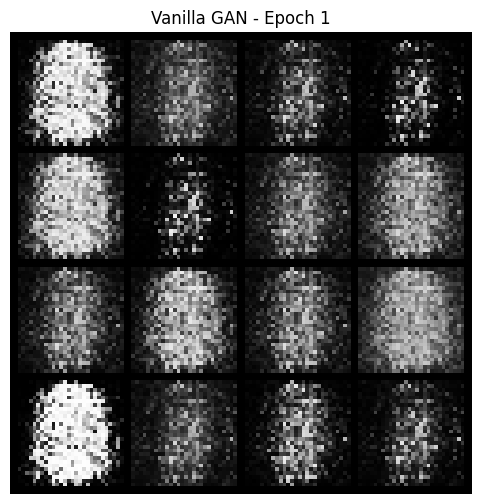

Epoch [2/5], Batch [100/469], D Loss: 0.7172, G Loss: 1.7647
Epoch [2/5], Batch [200/469], D Loss: 0.9262, G Loss: 2.4296
Epoch [2/5], Batch [300/469], D Loss: 0.6852, G Loss: 2.2280
Epoch [2/5], Batch [400/469], D Loss: 0.7224, G Loss: 2.7328
Epoch [2/5] completed - Avg G Loss: 2.0710, Avg D Loss: 0.8725


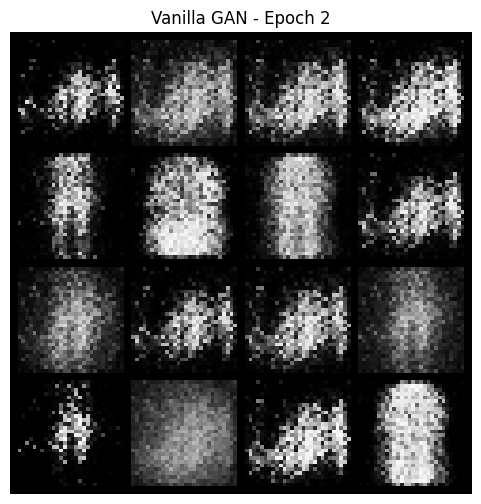

Epoch [3/5], Batch [100/469], D Loss: 1.0983, G Loss: 1.0217
Epoch [3/5], Batch [200/469], D Loss: 1.1663, G Loss: 1.3077
Epoch [3/5], Batch [300/469], D Loss: 0.9460, G Loss: 1.6920
Epoch [3/5], Batch [400/469], D Loss: 0.8871, G Loss: 1.9210
Epoch [3/5] completed - Avg G Loss: 2.0663, Avg D Loss: 0.9087


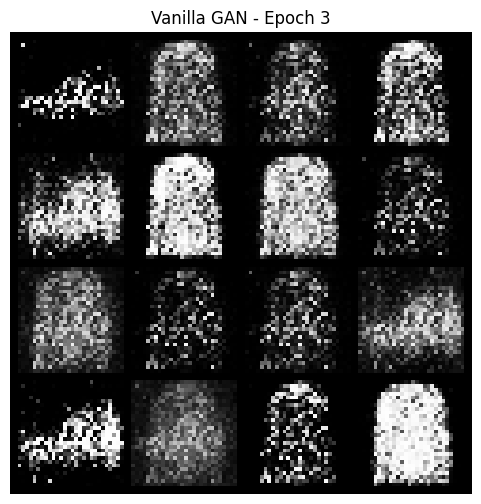

Epoch [4/5], Batch [100/469], D Loss: 0.8987, G Loss: 2.1894
Epoch [4/5], Batch [200/469], D Loss: 0.8263, G Loss: 2.0489
Epoch [4/5], Batch [300/469], D Loss: 1.0805, G Loss: 1.8075
Epoch [4/5], Batch [400/469], D Loss: 1.1195, G Loss: 2.0639
Epoch [4/5] completed - Avg G Loss: 1.7182, Avg D Loss: 0.9908


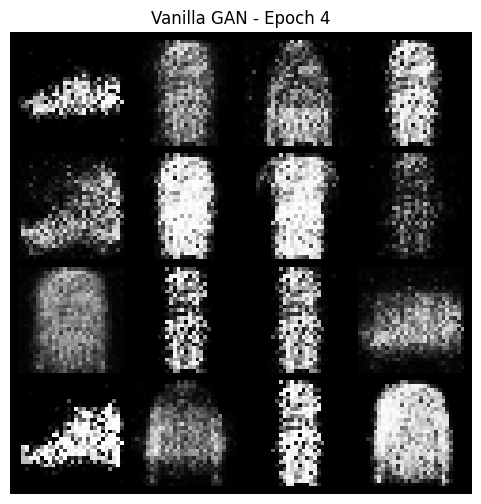

Epoch [5/5], Batch [100/469], D Loss: 1.1791, G Loss: 1.1307
Epoch [5/5], Batch [200/469], D Loss: 1.2693, G Loss: 1.0821
Epoch [5/5], Batch [300/469], D Loss: 1.1945, G Loss: 0.7175
Epoch [5/5], Batch [400/469], D Loss: 1.0227, G Loss: 1.9042
Epoch [5/5] completed - Avg G Loss: 1.4113, Avg D Loss: 1.1002


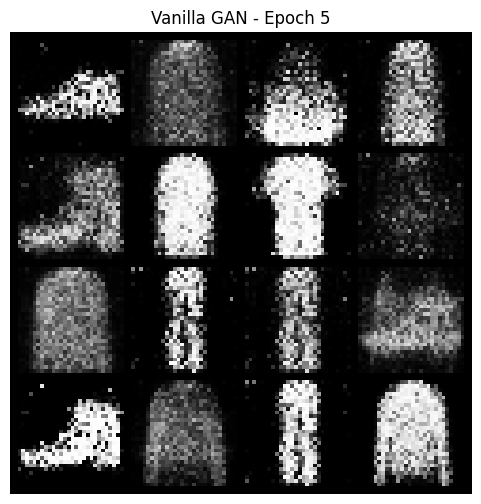

Vanilla GAN Training Complete!


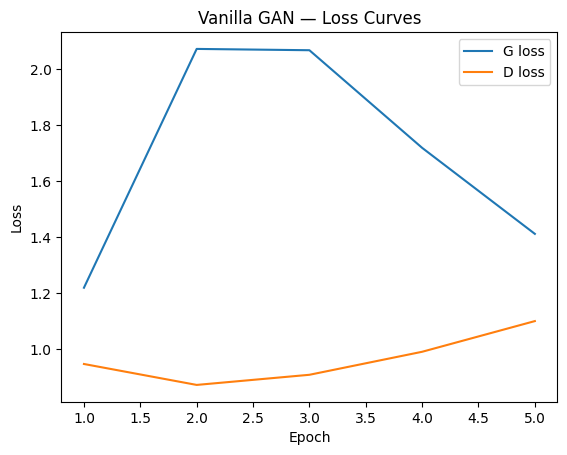

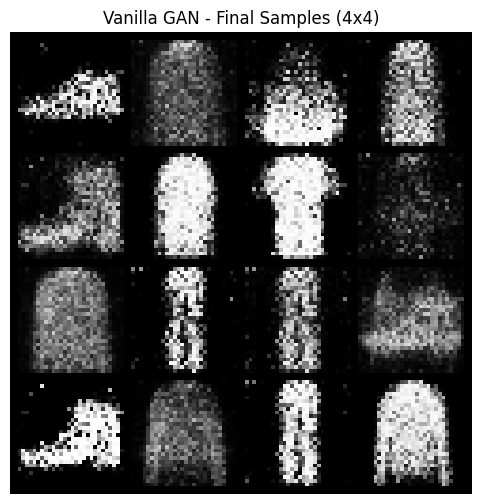

In [ ]:
# Train Vanilla GAN for 5 epochs (demo)
print("Starting Vanilla GAN Training...")

for epoch in range(epochs_gan):
    epoch_G_loss = 0.0
    epoch_D_loss = 0.0
    num_batches = 0

    for i, (real_imgs, _) in enumerate(train_loader):
        batch_size_current = real_imgs.size(0)
        real_imgs = real_imgs.to(device)

        # Labels for real and fake images
        real_labels = torch.ones(batch_size_current, 1, device=device)
        fake_labels = torch.zeros(batch_size_current, 1, device=device)

        opt_D_A.zero_grad()

        # Loss on real images
        real_outputs = D_A(real_imgs)
        loss_D_real = criterion_bce(real_outputs, real_labels)

        # Loss on fake images
        z = torch.randn(batch_size_current, latent_dim, device=device)
        fake_imgs = G_A(z)
        fake_outputs = D_A(fake_imgs.detach())  # detach to avoid backprop through G
        loss_D_fake = criterion_bce(fake_outputs, fake_labels)

        # Total discriminator loss
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        opt_D_A.step()

        opt_G_A.zero_grad()

        # Generator wants discriminator to classify fake images as real
        fake_outputs = D_A(fake_imgs)  # no detach here
        loss_G = criterion_bce(fake_outputs, real_labels)  # try to fool D

        loss_G.backward()
        opt_G_A.step()

        # Accumulate losses
        epoch_G_loss += loss_G.item()
        epoch_D_loss += loss_D.item()
        num_batches += 1

        # Print progress every 100 batches
        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs_gan}], Batch [{i+1}/{len(train_loader)}], "
                  f"D Loss: {loss_D.item():.4f}, G Loss: {loss_G.item():.4f}")

    # Average losses for the epoch
    avg_G_loss = epoch_G_loss / num_batches
    avg_D_loss = epoch_D_loss / num_batches
    losses_G_A.append(avg_G_loss)
    losses_D_A.append(avg_D_loss)

    print(f"Epoch [{epoch+1}/{epochs_gan}] completed - Avg G Loss: {avg_G_loss:.4f}, Avg D Loss: {avg_D_loss:.4f}")

    # Generate samples after each epoch
    with torch.no_grad():
        fake_samples = G_A(fixed_noise)
    show_grid(fake_samples[:16], title=f"Vanilla GAN - Epoch {epoch+1}", nrow=4)

print("Vanilla GAN Training Complete!")

# Plot losses
plt.figure()
plt.plot(range(1, epochs_gan+1), losses_G_A, label="G loss")
plt.plot(range(1, epochs_gan+1), losses_D_A, label="D loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Vanilla GAN — Loss Curves")
plt.legend(); plt.show()

# Generate final 4x4 grid for report
with torch.no_grad():
    final_samples = G_A(fixed_noise[:16])
show_grid(final_samples, title="Vanilla GAN - Final Samples (4x4)", nrow=4)



## Part B — Implementing a Wasserstein GAN (WGAN)

**Goal:** Replace BCE/sigmoid with the Wasserstein formulation and a Critic (no sigmoid) + Gradient Penalty.

1. Write the Critic architecture

In [ ]:
# TODO: Adjust the Critic architecture (remove sigmoid)
latent_dim = 64

class GenB(nn.Module):
    def __init__(self, z_dim=latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 28*28),
            nn.Tanh(),  # [-1,1]
        )
    def forward(self, z):
        return self.net(z).view(-1, 1, 28, 28)

class CriticB(nn.Module):
    """
    Critic network for WGAN-GP.
    Key difference from Discriminator: NO sigmoid activation at the end.
    Outputs raw scores (not probabilities).
    """
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            # NO Sigmoid
        )

    def forward(self, x):
        return self.net(x.view(x.size(0), -1))

G_B = GenB().to(device)
C_B = CriticB().to(device)


2. Implement a helper function to compute the gradient penalty (GP) using λ = 10.

In [ ]:
# TODO: Implement Wasserstein losses and Gradient Penalty helper
def gradient_penalty(critic, real, fake, lambda_gp=10.0):
    """
    Computes gradient penalty for WGAN-GP.

    The gradient penalty enforces the Lipschitz constraint by penalizing
    the critic if its gradient norm deviates from 1 on interpolated samples.

    GP = λ * E[(||∇_x̂ C(x̂)||_2 - 1)^2]
    where x̂ = ε*real + (1-ε)*fake, ε ~ U[0,1]

    Args:
        critic: The critic network
        real: Real images batch
        fake: Fake images batch
        lambda_gp: Gradient penalty weight (default: 10.0)

    Returns:
        gp: Gradient penalty scalar
    """
    batch_size = real.size(0)

    # Random weight for interpolation (epsilon)
    epsilon = torch.rand(batch_size, 1, 1, 1, device=real.device)

    # Interpolated images: x̂ = ε*real + (1-ε)*fake
    interpolated = epsilon * real + (1 - epsilon) * fake
    interpolated.requires_grad_(True)

    # Get critic scores for interpolated images
    critic_interpolated = critic(interpolated)

    # Compute gradients of critic output w.r.t. interpolated images
    gradients = torch.autograd.grad(
        outputs=critic_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(critic_interpolated),
        create_graph=True,  # Required for second-order derivatives
        retain_graph=True,
        only_inputs=True,
    )[0]

    # Flatten gradients to compute norm
    gradients = gradients.view(batch_size, -1)

    # Compute gradient norm
    gradient_norm = gradients.norm(2, dim=1)

    # Compute gradient penalty: λ * E[(||∇||_2 - 1)^2]
    gp = lambda_gp * ((gradient_norm - 1) ** 2).mean()

    return gp

3. Use the Adam optimizer and set up training parameters as instructed

In [ ]:
epochs_wgan = 5

# WGAN-GP optimizer settings (as specified in assignment)
lr_wgan = 1e-4  # 1 × 10^-4
beta1_wgan = 0.5
beta2_wgan = 0.9

opt_G_B = torch.optim.Adam(G_B.parameters(), lr=lr_wgan, betas=(beta1_wgan, beta2_wgan))
opt_C_B = torch.optim.Adam(C_B.parameters(), lr=lr_wgan, betas=(beta1_wgan, beta2_wgan))

losses_G_B, losses_C_B = [], []
fixed_noise_B = torch.randn(64, latent_dim, device=device)

4. Train WGAN for 5 epochs
Plot both the Critic and Generator losses after each epoch, and generate a 4 × 4 grid of
16 sample images from the trained generator. Sample output is shown below:


WGAN-GP Training Configuration:
  Epochs: 5
  Learning rate: 0.0001
  Beta1: 0.5, Beta2: 0.9
  Lambda GP: 10.0

Starting WGAN-GP Training...

Epoch [1/5], Batch [100/469], C Loss: -13.7567, G Loss: -1.0774
Epoch [1/5], Batch [200/469], C Loss: -7.5323, G Loss: -2.8554
Epoch [1/5], Batch [300/469], C Loss: -8.8954, G Loss: 8.9721
Epoch [1/5], Batch [400/469], C Loss: -7.8302, G Loss: 3.9884
Epoch [1/5] completed - Avg G Loss: 1.0109, Avg C Loss: -8.8513


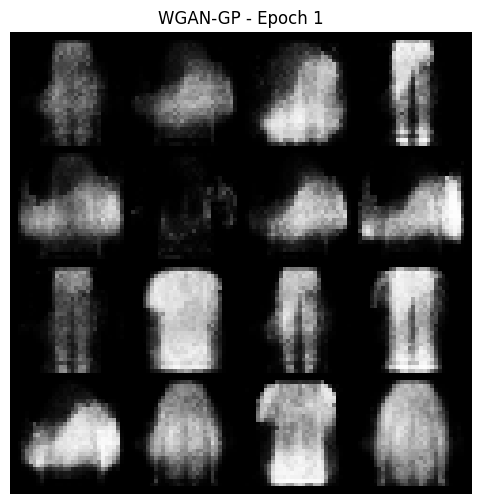

Epoch [2/5], Batch [100/469], C Loss: -6.2915, G Loss: 1.8986
Epoch [2/5], Batch [200/469], C Loss: -5.3005, G Loss: 0.2881
Epoch [2/5], Batch [300/469], C Loss: -5.5107, G Loss: 2.8106
Epoch [2/5], Batch [400/469], C Loss: -4.9893, G Loss: -0.1400
Epoch [2/5] completed - Avg G Loss: 1.2766, Avg C Loss: -5.7777


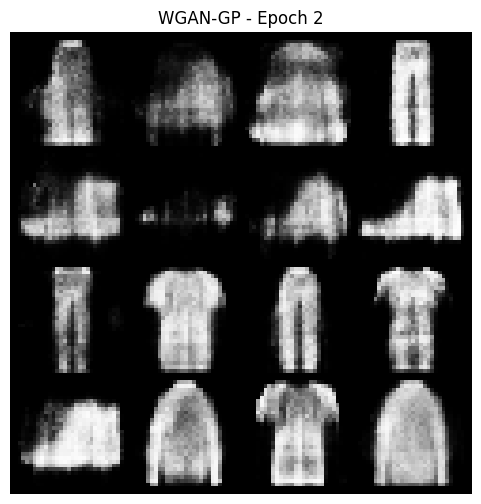

Epoch [3/5], Batch [100/469], C Loss: -6.0664, G Loss: 1.3834
Epoch [3/5], Batch [200/469], C Loss: -4.3053, G Loss: 0.8411
Epoch [3/5], Batch [300/469], C Loss: -4.5527, G Loss: 0.9052
Epoch [3/5], Batch [400/469], C Loss: -4.8070, G Loss: 1.2759
Epoch [3/5] completed - Avg G Loss: 1.0415, Avg C Loss: -4.8604


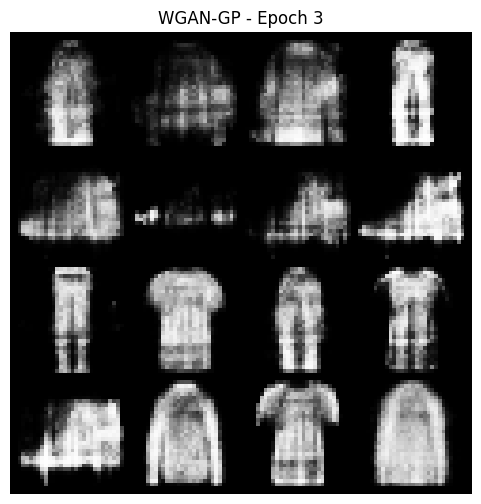

Epoch [4/5], Batch [100/469], C Loss: -4.8064, G Loss: 1.6856
Epoch [4/5], Batch [200/469], C Loss: -4.2554, G Loss: 1.5071
Epoch [4/5], Batch [300/469], C Loss: -4.6363, G Loss: 0.0309
Epoch [4/5], Batch [400/469], C Loss: -4.2342, G Loss: -0.2822
Epoch [4/5] completed - Avg G Loss: 0.8424, Avg C Loss: -4.2535


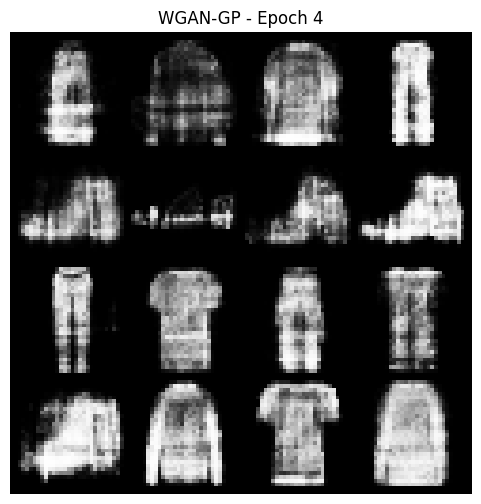

Epoch [5/5], Batch [100/469], C Loss: -3.7837, G Loss: -0.7454
Epoch [5/5], Batch [200/469], C Loss: -3.4717, G Loss: 0.7027
Epoch [5/5], Batch [300/469], C Loss: -4.1893, G Loss: 0.5097
Epoch [5/5], Batch [400/469], C Loss: -3.6884, G Loss: 1.7779
Epoch [5/5] completed - Avg G Loss: 0.7835, Avg C Loss: -3.7651


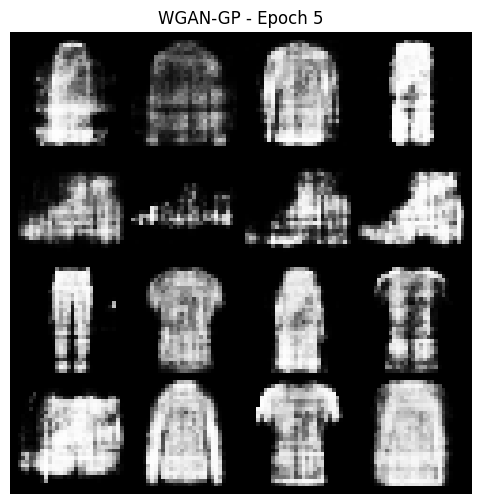


WGAN-GP Training Complete!


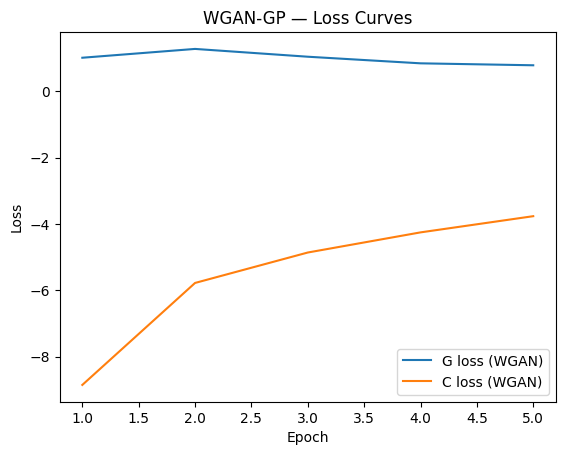

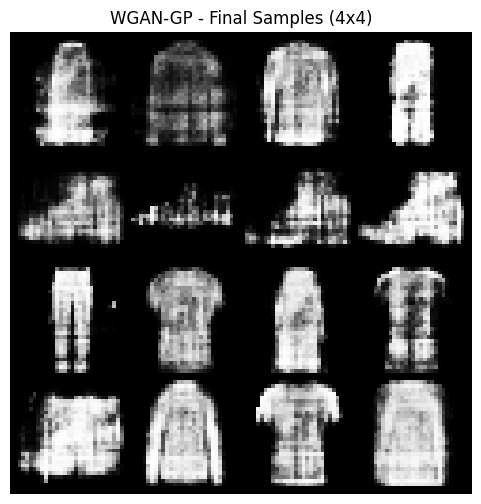

In [ ]:
# Train WGAN-GP for 5 epochs
print(f"\nWGAN-GP Training Configuration:")
print(f"  Epochs: {epochs_wgan}")
print(f"  Learning rate: {lr_wgan}")
print(f"  Beta1: {beta1_wgan}, Beta2: {beta2_wgan}")
print(f"  Lambda GP: 10.0")

print("\nStarting WGAN-GP Training...\n")

n_critic = 5  # Train critic more times than generator (common practice)
lambda_gp = 10.0

for epoch in range(epochs_wgan):
    epoch_G_loss = 0.0
    epoch_C_loss = 0.0
    num_batches = 0

    for i, (real_imgs, _) in enumerate(train_loader):
        batch_size_current = real_imgs.size(0)
        real_imgs = real_imgs.to(device)

        for _ in range(n_critic):
            opt_C_B.zero_grad()

            # Generate fake images
            z = torch.randn(batch_size_current, latent_dim, device=device)
            fake_imgs = G_B(z)

            # Critic scores
            critic_real = C_B(real_imgs)
            critic_fake = C_B(fake_imgs.detach())

            # Wasserstein loss: maximize E[C(real)] - E[C(fake)]
            # For the critic, we minimize the negative: -E[C(real)] + E[C(fake)]
            loss_C_wasserstein = -critic_real.mean() + critic_fake.mean()

            # Gradient penalty
            gp = gradient_penalty(C_B, real_imgs, fake_imgs, lambda_gp=lambda_gp)

            # Total critic loss: Wasserstein loss + GP
            loss_C = loss_C_wasserstein + gp

            loss_C.backward()
            opt_C_B.step()

        opt_G_B.zero_grad()

        # Generate fake images
        z = torch.randn(batch_size_current, latent_dim, device=device)
        fake_imgs = G_B(z)

        # Generator loss: maximize E[C(fake)] = minimize -E[C(fake)]
        critic_fake = C_B(fake_imgs)
        loss_G = -critic_fake.mean()

        loss_G.backward()
        opt_G_B.step()

        # Accumulate losses
        epoch_G_loss += loss_G.item()
        epoch_C_loss += loss_C.item()
        num_batches += 1

        # Print progress every 100 batches
        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs_wgan}], Batch [{i+1}/{len(train_loader)}], "
                  f"C Loss: {loss_C.item():.4f}, G Loss: {loss_G.item():.4f}")

    # Average losses for the epoch
    avg_G_loss = epoch_G_loss / num_batches
    avg_C_loss = epoch_C_loss / num_batches
    losses_G_B.append(avg_G_loss)
    losses_C_B.append(avg_C_loss)

    print(f"Epoch [{epoch+1}/{epochs_wgan}] completed - Avg G Loss: {avg_G_loss:.4f}, Avg C Loss: {avg_C_loss:.4f}")

    # Generate samples after each epoch
    with torch.no_grad():
        fake_samples = G_B(fixed_noise_B)
    show_grid(fake_samples[:16], title=f"WGAN-GP - Epoch {epoch+1}", nrow=4)

print("\nWGAN-GP Training Complete!")

# Plot losses
plt.figure()
plt.plot(range(1, epochs_wgan+1), losses_G_B, label="G loss (WGAN)")
plt.plot(range(1, epochs_wgan+1), losses_C_B, label="C loss (WGAN)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("WGAN-GP — Loss Curves")
plt.legend(); plt.show()

# Generate final 4x4 grid for report
with torch.no_grad():
    final_samples_wgan = G_B(fixed_noise_B[:16])
show_grid(final_samples_wgan, title="WGAN-GP - Final Samples (4x4)", nrow=4)


## Comparison & Wrap-up

- Compare the **Vanilla GAN** and **WGAN-GP** losses and sample grids.
- Expect WGAN-GP to exhibit smoother, more stable training and often better-looking samples within 5 epochs.


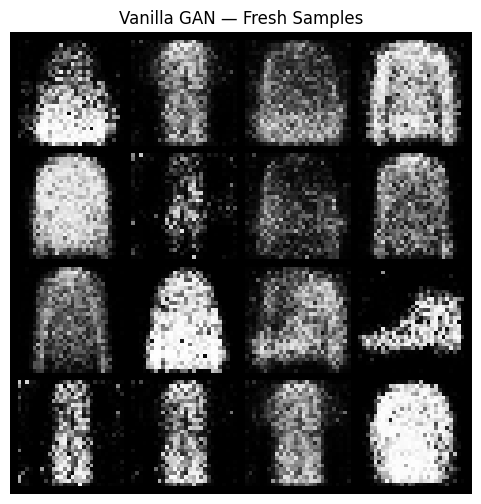

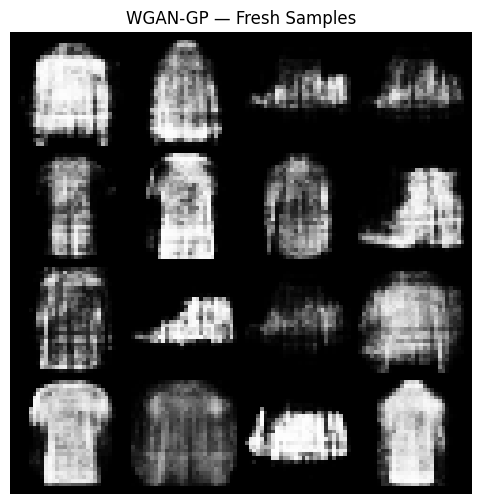

In [ ]:

# (Instructor note: keep)
# Optional: Generate fresh grids for side-by-side qualitative comparison
with torch.no_grad():
    grid_gan  = G_A(torch.randn(16, latent_dim, device=device))
    grid_wgan = G_B(torch.randn(16, latent_dim, device=device))

show_grid(grid_gan,  title="Vanilla GAN — Fresh Samples", nrow=4)
show_grid(grid_wgan, title="WGAN-GP — Fresh Samples",   nrow=4)


5. How do the training behaviour and image quality differ from the vanilla GAN?